# Comparing meta-learners across simulation setups
This notebook compares X-, R-, T- and S-learners across the simulation setups discussed by [Nie and Wager (2020)](https://arxiv.org/pdf/1712.04912.pdf). Note that the experiments don't include the parameter tuning described in the paper.

In [1]:
import numpy as np
import pandas as pd

from causalml.inference.meta import BaseSRegressor
from causalml.inference.meta import BaseTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor

from causalml.dataset import synthetic_data

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, Lasso
from xgboost import XGBRegressor

from copy import deepcopy
from itertools import product

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.0


In [3]:
def run_experiments(n_list, p_list, s_list, m_list, learner_dict, num_iter,
                    propensity_learner):
    
    result_list = []    

    for i in tqdm(range(num_iter)):
        
        for n, p, s, m, learner in product(n_list, p_list, s_list, m_list, learner_dict.keys()):

            y, X, W, tau, _, _ = synthetic_data(mode=m, n=n, p=p, sigma=s)
            X_train, X_test, W_train, _, y_train, _, _, tau_test = train_test_split(
                X, W, y, tau, test_size=0.2, random_state=111)

            if propensity_learner is not None:
                em = clone(propensity_learner)
                em.fit(X_train, W_train)
                e_hat_train = cross_val_predict(em, X_train, W_train, method='predict_proba')[:, 1]
                e_hat_test = em.predict_proba(X_test)[:, 1]

            model = deepcopy(learner_dict[learner])
            model.fit(X=X_train, treatment=W_train, y=y_train, p=e_hat_train)
            hat_tau = model.predict(X_test, p=e_hat_test)

            pehe = mean_squared_error(tau_test, hat_tau)

            result_list.append([n, p, s, m, learner, pehe])
    
    cols = ['num_samples', 'num_features', 'sigma', 'sim_mode', 'learner', 'pehe']
    df_res = pd.DataFrame(result_list, columns=cols)
    return df_res

## Lasso based experiments

In [4]:
# Simulation params from Nie and Wager (2020)
n_list = [100, 500]
p_list = [6, 12]
s_list = [0.5, 1, 2, 4]
m_list = [1, 2, 3, 4]
num_iter = 100

learner_dict = {
    'S-Learner': BaseSRegressor(learner=Lasso()),
    'T-Learner': BaseTRegressor(learner=Lasso()),
    'X-Learner': BaseXRegressor(learner=Lasso()),
    'R-Learner': BaseRRegressor(learner=Lasso())
}

propensity_learner = LogisticRegression(penalty='l1', solver='liblinear')

df_res_lasso = run_experiments(n_list, p_list, s_list, m_list, learner_dict, num_iter, propensity_learner=propensity_learner)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [12:33<00:00,  7.54s/it]


In [5]:
df_res_lasso.groupby(['learner', 'sim_mode'])['pehe'].median()

learner    sim_mode
R-Learner  1           0.136804
           2           1.222484
           3           0.060475
           4           1.790484
S-Learner  1           0.291730
           2           1.891915
           3           1.000000
           4           1.684261
T-Learner  1           0.209068
           2           1.272541
           3           2.158086
           4           1.849211
X-Learner  1           0.215715
           2           1.295758
           3           1.927569
           4           1.873567
Name: pehe, dtype: float64

In [6]:
data_generation_descs = {
    1: 'Difficult nuisance and easy treatment',
    2: 'Randomized trial',
    3: 'Easy propensity and a difficult baseline',
    4: 'Unrelated treatment and control'
}

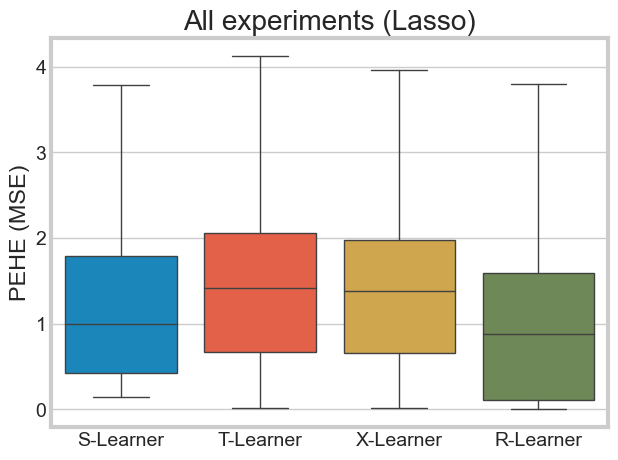

In [7]:
sns.boxplot(x='learner', y='pehe', data=df_res_lasso, linewidth=1, showfliers=False)
plt.ylabel('PEHE (MSE)')
plt.xlabel('')
plt.title('All experiments (Lasso)')
plt.show()

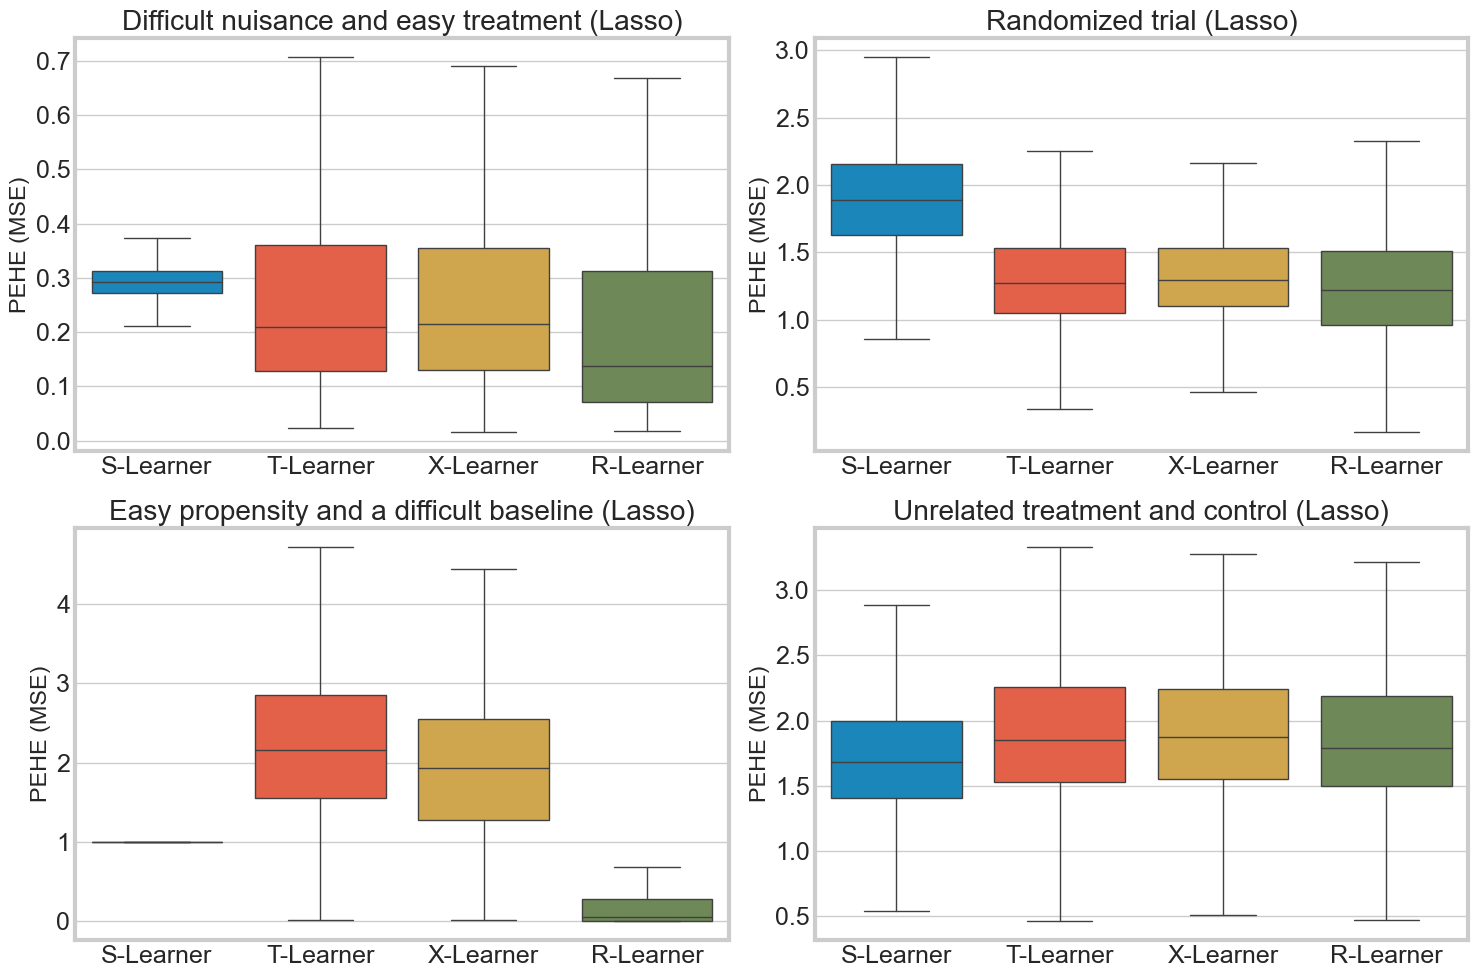

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, m in zip(range(4), m_list):
    sns.boxplot(x='learner', y='pehe', data=df_res_lasso.loc[df_res_lasso['sim_mode'] == m], linewidth=1, showfliers=False, ax=axs[i])
    axs[i].title.set_text(data_generation_descs[m] + ' (Lasso)')
    axs[i].set_ylabel('PEHE (MSE)')
    axs[i].set_xlabel('') # Hack
    axs[i].tick_params(labelsize=18)
plt.tight_layout()

## Gradient boosting based experiments

In [9]:
n_list = [500, 1000]
p_list = [6, 12]
s_list = [0.5, 1, 2, 4]
m_list = [1, 2, 3, 4]
num_iter = 100

learner_dict = {
    'S-Learner': BaseSRegressor(learner=XGBRegressor(n_jobs=-1)),
    'T-Learner': BaseTRegressor(learner=XGBRegressor(n_jobs=-1)),
    'X-Learner': BaseXRegressor(learner=XGBRegressor(n_jobs=-1)),
    'R-Learner': BaseRRegressor(learner=XGBRegressor(n_jobs=-1))
}

propensity_learner = LogisticRegression(penalty='l1', solver='liblinear')

df_res_xgb = run_experiments(n_list, p_list, s_list, m_list, learner_dict, num_iter, propensity_learner=propensity_learner)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [4:33:11<00:00, 163.91s/it]  


In [10]:
df_res_xgb.groupby(['learner', 'sim_mode'])['pehe'].median()

learner    sim_mode
R-Learner  1           5.461846
           2           3.711489
           3           6.784913
           4           5.799527
S-Learner  1           0.370339
           2           0.783766
           3           0.516728
           4           1.036608
T-Learner  1           1.327521
           2           1.773152
           3           2.301350
           4           1.572995
X-Learner  1           0.738517
           2           0.771464
           3           0.799456
           4           1.163700
Name: pehe, dtype: float64

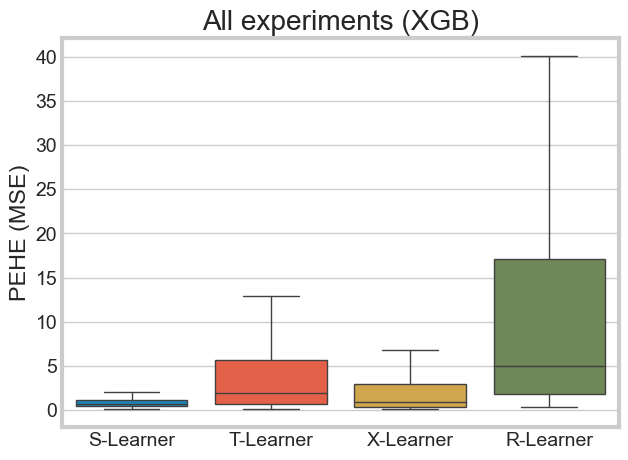

In [11]:
sns.boxplot(x='learner', y='pehe', data=df_res_xgb, linewidth=1, showfliers=False)
plt.ylabel('PEHE (MSE)')
plt.xlabel('')
plt.title('All experiments (XGB)')
plt.show()

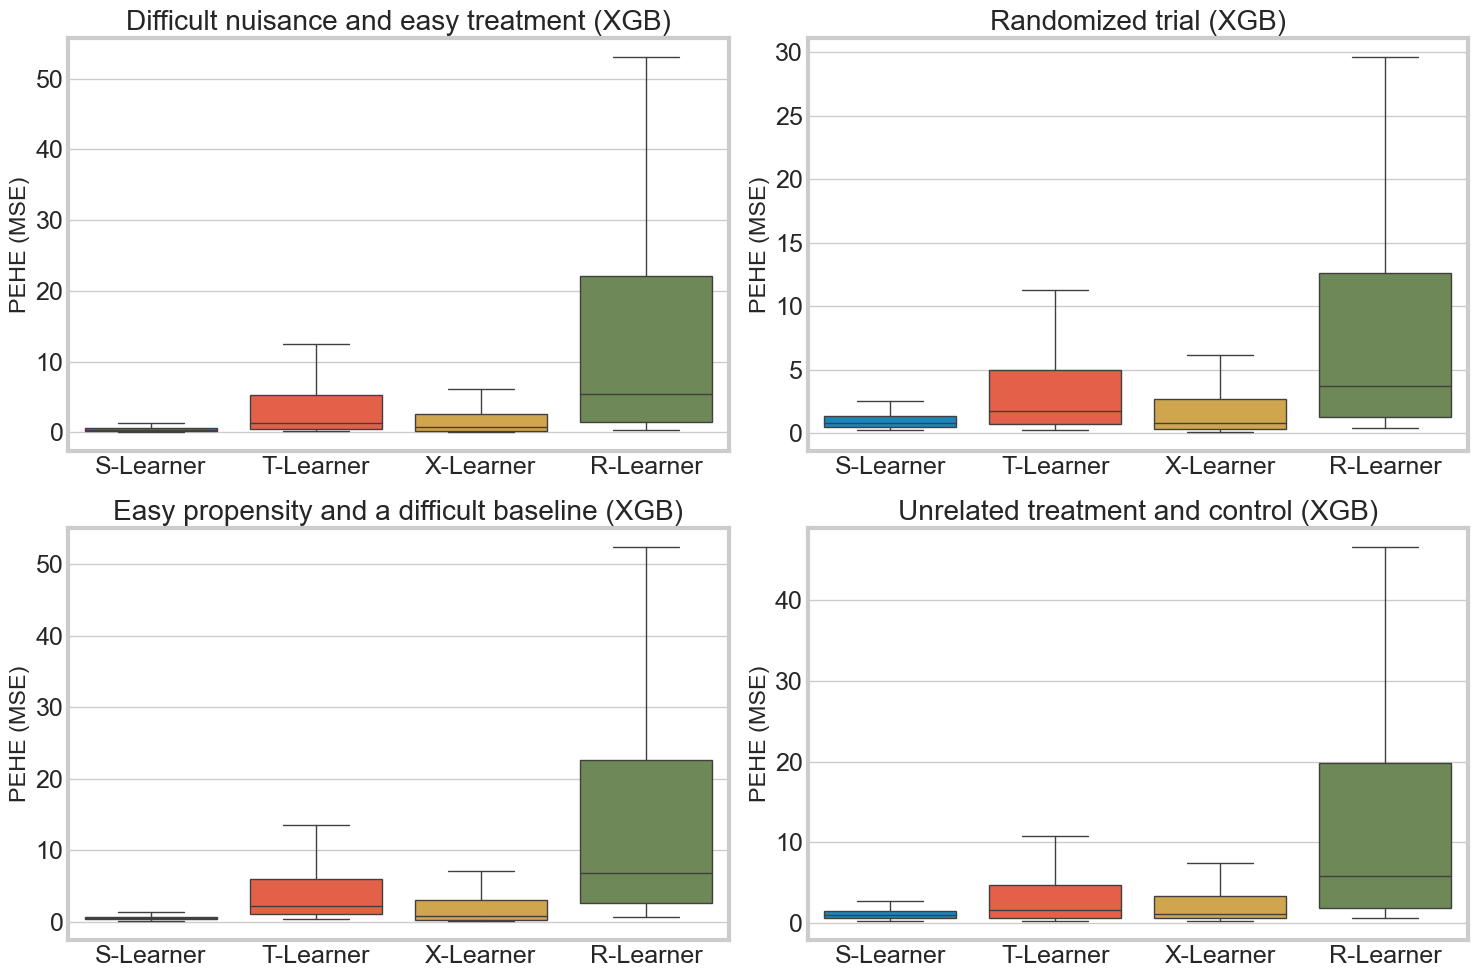

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()
for i, m in zip(range(4), m_list):
    sns.boxplot(x='learner', y='pehe', data=df_res_xgb.loc[df_res_xgb['sim_mode'] == m], linewidth=1, showfliers=False, ax=axs[i])
    axs[i].title.set_text(data_generation_descs[m] + ' (XGB)')
    axs[i].set_ylabel('PEHE (MSE)')
    axs[i].set_xlabel('') # Hack
    axs[i].tick_params(labelsize=18)
plt.tight_layout()